### WNT ROR interactions

In [1]:
import os
import requests
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
from ete3 import NCBITaxa

def fasta_to_dataframe(seq):
    fasta_df = pd.read_csv(seq, sep='>', lineterminator='>', header=None)
    fasta_df[['accession','sequence']]=fasta_df[0].str.split('\n', n=1, expand=True)
    fasta_df['sequence'] = fasta_df['sequence'].replace('\n','', regex=True)
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.sequence!='']
    final_df = fasta_df.dropna()
    return final_df

def parse_fasta_header(d):
    d['Entry'] = d.accession.str.split().apply(lambda x: x[0]).str.split('|').apply(lambda x: x[1])
    d['Name'] = d.accession.str.split().apply(lambda x: x[0]).str.split('|').apply(lambda x: x[2])
    d['Species'] = d.accession.str.split('OS=').apply(lambda x: x[1]).str.split(' OX=').apply(lambda x: x[0])
    d['taxid'] = d.accession.str.split('OS=').apply(lambda x: x[1]).str.split(' OX=').apply(lambda x: x[1]).str.split().apply(lambda x: x[0])
    d['GeneName'] = d.accession.str.split('GN=').apply(lambda x: x[-1]).str.split().apply(lambda x: x[0])
    return d

#### Get sequences from UniProt

In [2]:
wnt5a = fasta_to_dataframe('../data/wnt_ror/uniprotkb_WNT5A_2024_04_15.fasta.gz')
wnt5a = wnt5a[(wnt5a['accession'].str.contains('WNT5|Wnt5|wnt5')) & (~wnt5a['accession'].str.contains('5b|5B|Fragment'))].drop_duplicates('sequence').reset_index(drop=True)
wnt5a = parse_fasta_header(wnt5a)

wnt5b = fasta_to_dataframe('../data/wnt_ror/uniprotkb_WNT5B_2024_04_15.fasta.gz')
wnt5b = wnt5b[(wnt5b['accession'].str.contains('WNT5|Wnt5|wnt5')) & (~wnt5b['accession'].str.contains('5a|5A|Fragment'))].drop_duplicates('sequence').reset_index(drop=True)
wnt5b = parse_fasta_header(wnt5b)

ror1 = fasta_to_dataframe('../data/wnt_ror/uniprotkb_ROR1_2024_04_15.fasta.gz')
ror1 = ror1[(ror1['accession'].str.contains('ROR|Ror|ror')) & (~ror1['accession'].str.contains('ROR2|Ror2|ror2|Fragment'))].drop_duplicates('sequence').reset_index(drop=True)
ror1 = parse_fasta_header(ror1)

ror2 = fasta_to_dataframe('../data/wnt_ror/uniprotkb_ROR2_2024_04_15.fasta.gz')
ror2 = ror2[(ror2['accession'].str.contains('ROR|Ror|ror')) & (~ror2['accession'].str.contains('ROR1|Ror1|ror1|Fragment'))].drop_duplicates('sequence').reset_index(drop=True)
ror2 = parse_fasta_header(ror2)

# C. elegans wnt ror
wnt = fasta_to_dataframe('../data/wnt_ror/idmapping_2024_05_13.fasta.gz')
wnt = wnt[(wnt['accession'].str.contains('WNT|Wnt|wnt'))]
wnt = parse_fasta_header(wnt)
ror = fasta_to_dataframe('../data/wnt_ror/idmapping_2024_05_13.fasta.gz')
ror = ror[(ror['accession'].str.contains('receptor'))]
ror = parse_fasta_header(ror)

wnt5a = pd.concat([wnt5a,wnt])
ror1 = pd.concat([ror1,ror])

wnt5a.shape, wnt5b.shape, ror1.shape, ror2.shape

((278, 7), (287, 7), (622, 7), (522, 7))

#### Get NCBI taxonomy

In [3]:
wnt5_sp = set(wnt5a.taxid.tolist() + wnt5b.taxid.tolist())
ror_sp = set(ror1.taxid.tolist() + ror2.taxid.tolist())

sp = [list(wnt5_sp), list(ror_sp)]
sp = pd.DataFrame({'taxid':list(set.intersection(*[set(x) for x in sp]))})
len(sp.taxid.tolist())

203

In [5]:
# https://stackoverflow.com/a/43876587

ncbi = NCBITaxa()

def get_desired_ranks(taxid, desired_ranks):
    lineage = ncbi.get_lineage(taxid)   
    names = ncbi.get_taxid_translator(lineage)
    lineage2ranks = ncbi.get_rank(names)
    ranks2lineage = dict((rank,taxid) for (taxid, rank) in lineage2ranks.items())
    return{'{}_id'.format(rank): ranks2lineage.get(rank, '<not present>') for rank in desired_ranks}

if __name__ == '__main__':
    desired_ranks = ['kingdom', 'phylum', 'superclass', 'class', 'order', 'family', 'genus', 'species']
    lineages = []
    for taxid in sp.taxid.tolist():
        ranks = get_desired_ranks(taxid, desired_ranks)
        for key, rank in ranks.items():
            if rank != '<not present>':
                lineages.append([taxid,key.replace('_id',''),list(ncbi.get_taxid_translator([rank]).values())[0]])

lineages = pd.DataFrame(lineages, columns=['taxid','rank','lineage'])
lineages.to_pickle('../data/wnt_ror/lineages.pkl.gz')

In [4]:
wnt5a = pd.merge(wnt5a,sp)
wnt5b = pd.merge(wnt5b,sp)
ror1 = pd.merge(ror1,sp)
ror2 = pd.merge(ror2,sp)

wnt5a['Protein'] = 'WNT5A'
wnt5b['Protein'] = 'WNT5B'
ror1['Protein'] = 'ROR1'
ror2['Protein'] = 'ROR2'

pro = pd.concat([wnt5a,wnt5b,ror1,ror2]).drop_duplicates('Entry')
pro.value_counts('Protein')

Protein
ROR1     380
ROR2     355
WNT5B    279
WNT5A    267
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='lineage'>

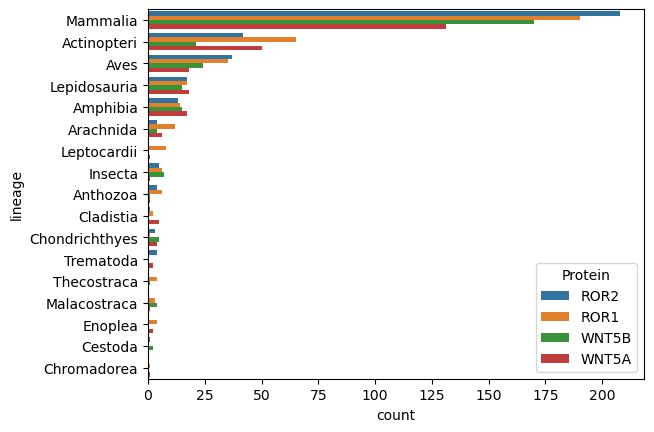

In [5]:
lineages = pd.read_pickle('../data/wnt_ror/lineages.pkl.gz')
prolin = pd.merge(lineages,pro)

prolin_counts = prolin.value_counts(['Protein','rank','lineage']).reset_index()
prolin_counts = prolin_counts[prolin_counts['rank']=='class'].drop('rank',axis=1)

sns.barplot(data=prolin_counts, x='count',y='lineage',hue='Protein')

#### Check the completeness of sequences through InterPro

In [8]:
acc = pro.Entry.tolist()
ipr = []

for k,v in enumerate(acc):
    api_url = "https://www.ebi.ac.uk/interpro/api/entry/all/protein/uniprot/"+ v +"?format=json"
    
    try:
        response = requests.get(api_url)
        r = pd.DataFrame(response.json()['results'])
    
        interpro = []
        
        for x in range(r.shape[0]):
            d = pd.DataFrame(r.proteins[0])[['accession','protein_length','source_database','organism']] 
            d['source_database_accession'] = r.metadata[x]['accession']
            d['name'] = r.metadata[x]['name']
            d['integrated'] = r.metadata[x]['integrated']
            f = pd.DataFrame(r.proteins[x][0]['entry_protein_locations'][0]['fragments'])
            d = pd.concat([d,f],axis=1)
            interpro.append(d)
       
        ipr.append(pd.concat(interpro))
        
    except ValueError:  # includes simplejson.decoder.JSONDecodeError
        print('Decoding JSON has failed for ' + v)

    print(str(k) + '/' + str(len(acc)), end='\r')

ipr = pd.concat(ipr)
ipr.to_pickle('../data/wnt_ror/ipr.pkl.gz')

Decoding JSON has failed for A0FKN4
Decoding JSON has failed for A0AA47MG15
Decoding JSON has failed for A0A8X6FMS1


/projects/health_sciences/bms/biochemistry/lim_group/cslim/anaconda3/lib/python3.12/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


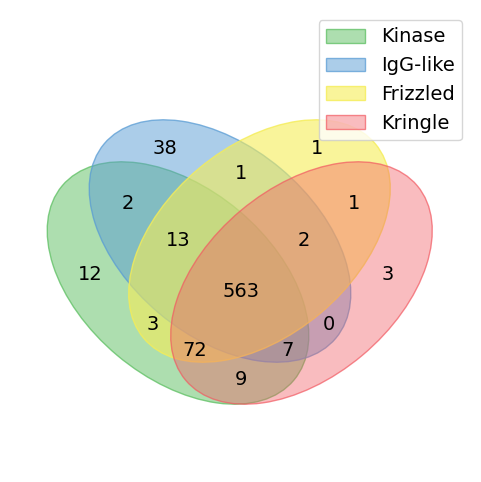

In [6]:
ipr = pd.read_pickle('../data/wnt_ror/ipr.pkl.gz')
ipr['Entry'] = ipr.accession.str.upper()
ipr = ipr.drop('accession',axis=1)

# RORs with IgG and Frizzled domains
import venn

ig = set(ipr[(ipr['name'].str.contains('mmunoglobulin|IG|Ig')) & (ipr['name'].notna())].Entry.tolist())
fzd = set(ipr[(ipr['name'].str.contains('ysteine|rizzled')) & (ipr['name'].notna())].Entry.tolist())
kr = set(ipr[(ipr['name'].str.contains('KR|Kr')) & (ipr['name'].notna())].Entry.tolist())
kinase = set(ipr[(ipr['name'].str.contains('inase')) & (ipr['name'].notna())].Entry.tolist())

labels = venn.generate_petal_labels([kinase, ig, fzd, kr])#, fill='number')
fig, ax = venn.venn4(labels, names=['Kinase', 'IgG-like', 'Frizzled', 'Kringle'], figsize=(6, 6))
fig.show()

In [7]:
# RORs with IgG and Frizzled domains
ig = set(ipr[(ipr['name'].str.contains('mmunoglobulin|IG|Ig')) & (ipr['name'].notna())].Entry.tolist())
fzd = set(ipr[(ipr['name'].str.contains('ysteine|rizzled')) & (ipr['name'].notna())].Entry.tolist())

ror = pd.DataFrame({'Entry':list(ig.intersection(fzd))})
ror = pd.merge(pro,ror)
ror.value_counts('Protein')

Protein
ROR1    301
ROR2    278
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='lineage'>

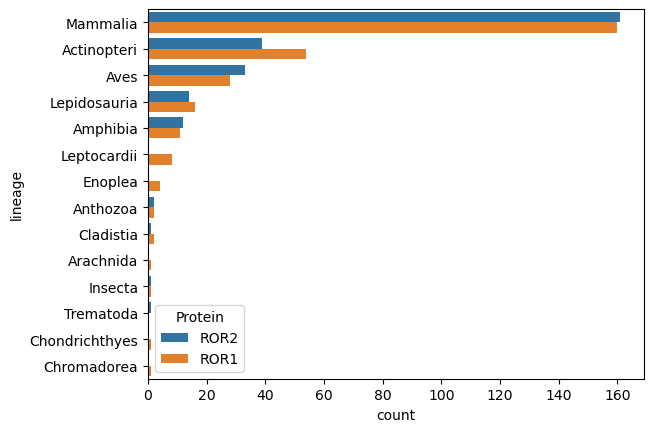

In [8]:
rorlin = pd.merge(lineages,ror)

rorlin_counts = rorlin.value_counts(['Protein','rank','lineage']).reset_index()
rorlin_counts = rorlin_counts[rorlin_counts['rank']=='class'].drop('rank',axis=1)
sns.barplot(data=rorlin_counts, x='count',y='lineage',hue='Protein')

<Axes: xlabel='count', ylabel='lineage'>

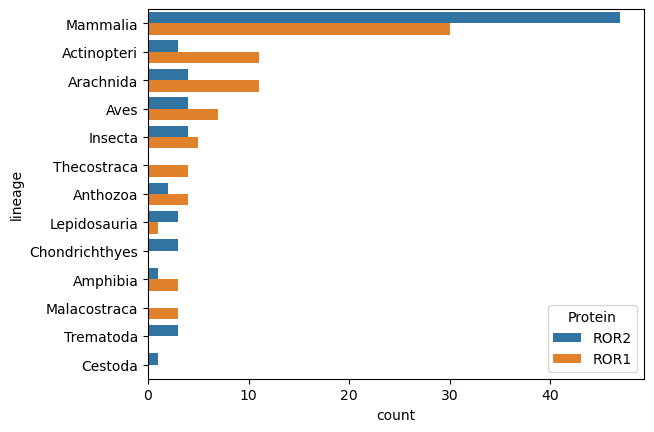

In [9]:
# RORs without IgG and Frizzled domains
ror_ = pd.concat([pro[pro.Protein.str.contains('ROR')],ror]).drop_duplicates('Entry',keep=False)
ror_lin = pd.merge(lineages,ror_)

ror_lin_counts = ror_lin.value_counts(['Protein','rank','lineage']).reset_index()
ror_lin_counts = ror_lin_counts[ror_lin_counts['rank']=='class'].drop('rank',axis=1)

sns.barplot(data=ror_lin_counts, x='count',y='lineage',hue='Protein')

In [10]:
# Genera containing RORs without IgG or Frizzled domains
rorsp = set(ror.Species.str.split().apply(lambda x: x[0]).tolist())
ror_sp = set(ror_.Species.str.split().apply(lambda x: x[0]).tolist())
len(ror_sp.difference(rorsp)), len(rorsp.difference(ror_sp))

(19, 100)

In [11]:
# Append the entries for the 19 genera back to ROR data
ror_['genus'] = ror_.Species.str.split().apply(lambda x: x[0])
ror_ = pd.merge(ror_, pd.DataFrame({'genus':list(ror_sp.difference(rorsp))}))
ror = pd.concat([ror,ror_])
ror.value_counts('Protein')

Protein
ROR1    332
ROR2    291
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='lineage'>

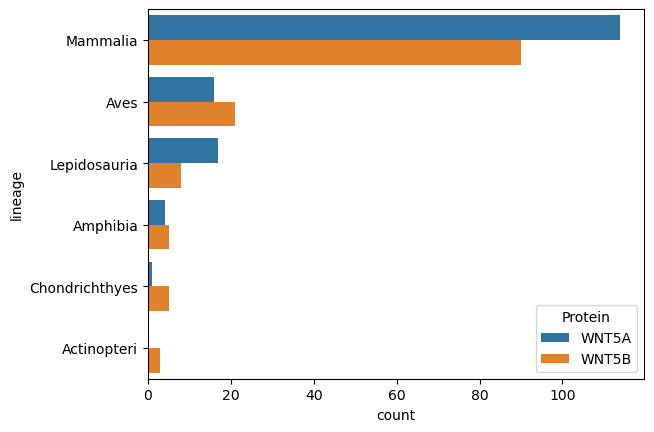

In [12]:
# WNT CDD IDs cd19347 cd19348
wnt5 = ipr[(ipr.source_database_accession.str.contains('cd19347|cd19348')) & (ipr.source_database_accession.notna())]
wnt5 = pd.merge(pro,wnt5[['Entry']].drop_duplicates())
wnt5lin = pd.merge(lineages,wnt5)

wnt5lin_counts = wnt5lin.value_counts(['Protein','rank','lineage']).reset_index()
wnt5lin_counts = wnt5lin_counts[wnt5lin_counts['rank']=='class'].drop('rank',axis=1)
sns.barplot(data=wnt5lin_counts, x='count',y='lineage',hue='Protein')

<Axes: xlabel='count', ylabel='lineage'>

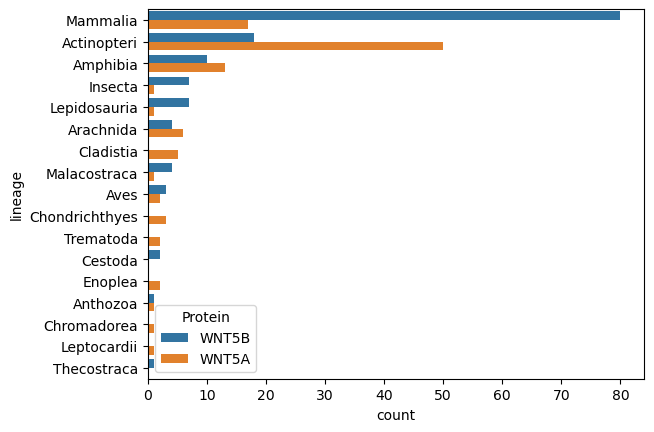

In [13]:
# WNT CDD IDs that are not cd19347 cd19348
wnt5_ = pd.concat([pro[pro.Protein.str.contains('WNT')],wnt5]).drop_duplicates('Entry',keep=False)
wnt5_lin = pd.merge(lineages,wnt5_)

wnt5_lin_counts = wnt5_lin.value_counts(['Protein','rank','lineage']).reset_index()
wnt5_lin_counts = wnt5_lin_counts[wnt5_lin_counts['rank']=='class'].drop('rank',axis=1)

sns.barplot(data=wnt5_lin_counts, x='count',y='lineage',hue='Protein')

In [14]:
# Genera containing RORs without IgG or Frizzled domains
wnt5sp = set(wnt5.Species.str.split().apply(lambda x: x[0]).tolist())
wnt5_sp = set(wnt5_.Species.str.split().apply(lambda x: x[0]).tolist())
len(wnt5_sp.difference(wnt5sp)), len(wnt5sp.difference(wnt5_sp))

(58, 67)

In [15]:
# Append the entries for the 19 genera back to ROR data
wnt5_['genus'] = wnt5_.Species.str.split().apply(lambda x: x[0])
wnt5_ = pd.merge(wnt5_, pd.DataFrame({'genus':list(wnt5_sp.difference(wnt5sp))}))
wnt5 = pd.concat([wnt5,wnt5_])
wnt5.value_counts('Protein')

Protein
WNT5A    243
WNT5B    191
Name: count, dtype: int64

In [16]:
pro = pd.concat([ror,wnt5])
pro.to_pickle('../data/wnt_ror/pro.pkl.gz')
pro['fasta_header'] = '>' + pro.accession
pro[['fasta_header','sequence']].to_csv('../data/wnt_ror/pro.fa', 
                                        index=False,header=False,sep='\n')

pro.value_counts('Protein')

Protein
ROR1     332
ROR2     291
WNT5A    243
WNT5B    191
Name: count, dtype: int64

#### Fetch WNT and ROR profile hmm models and run hmmsearch

```
wget https://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam36.0/Pfam-A.hmm.gz
# WNT
mkdir ref
hmmfetch Pfam-A.hmm.gz PF00110.23 > ../data/wnt_ror/wnt_ror.hmm
# ROR
for i in PF00051.22 PF07714.21 PF01392.26 PF07679.20; do \
hmmfetch Pfam-A.hmm.gz $i
done >> ../data/wnt_ror/wnt_ror.hmm

zcat \
../data/wnt_ror/idmapping_2024_05_13.fasta \
| cat - ../data/wnt_ror/pro.fa \
> ../data/wnt_ror/pro.fas
mv ../data/wnt_ror/pro.fas ../data/wnt_ror/pro.fa

hmmsearch \
--cpu 8 \
--domtblout ../data/wnt_ror/pro.domtblout \
../data/wnt_ror/wnt_ror.hmm \
../data/wnt_ror/pro.fa

#### Parse hmmsearch output

In [2]:
from collections import defaultdict
from Bio import SearchIO

filename = '../data/wnt_ror/pro.domtblout'

# https://biopython.org/docs/1.75/api/Bio.SearchIO.HmmerIO.html
hsp_attribs = ['hit_id','query_id','acc_avg','bias','bitscore','domain_index','env_start','env_end','evalue','evalue_cond','hit_start','hit_end','query_start','query_end']
# https://biofold.org/pages/courses/lb1-2/docs/6-HMMER.pdf
# !: pass both per-domain and per-sequence E-value thresholds (0.001). 
# ?: pass only one E-value threshold
# c-Evalue: conditional 
# E-value: statistical significance of the domain given that we know that the sequence is a true homolog 
# i-Evalue: independent E-value: statistical significance of the best domain identified in the sequence. Then the portions of the aligned HMM and the sequence are provided 
# Envelope is the best aligned sequence portion 
# Acc: mean per residue alignment a–posteriori probability

hsps = defaultdict(list)

hit_attribs = ['id','description','seq_len','bias','bitscore','evalue',]
hits = defaultdict(list)

with open(filename) as handle:
    for queryresult in SearchIO.parse(handle, 'hmmsearch3-domtab'):
        for hit in queryresult.hits:
            for hit_attrib in hit_attribs:
                hits[hit_attrib].append(getattr(hit, hit_attrib))
        for hsp in queryresult.hsps:
            for hsp_attrib in hsp_attribs:
                hsps[hsp_attrib].append(getattr(hsp, hsp_attrib))
                
hits_df = pd.DataFrame.from_dict(hits)
hsps_df = pd.DataFrame.from_dict(hsps)
hits_df.rename(columns={'id':'hit_id','bias':'overall_bias','bitscore':'overall_bitscore','evalue':'overall_evalue'}, inplace=True)
domtblout = pd.merge(hits_df[['hit_id','description']],hsps_df).drop_duplicates()
domtblout['env_start'] = domtblout.env_start.apply(lambda x: x-1 if x!=0 else x)
domtblout['query_start'] = domtblout.query_start.apply(lambda x: x-1 if x!=0 else x)
domtblout['coverage'] = (domtblout.env_end-domtblout.env_start)/ (np.max(domtblout.query_end.tolist())-np.min(domtblout.query_start.tolist()))
domtblout[domtblout.coverage>0.2].value_counts('query_id')

query_id
Fz                600
PK_Tyr_Ser-Thr    600
I-set             593
Kringle           590
wnt               443
Name: count, dtype: int64

<Axes: xlabel='coverage', ylabel='bitscore'>

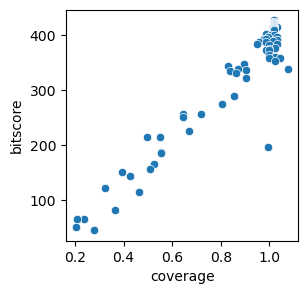

In [3]:
domtblout = domtblout[domtblout.coverage>0.2]
wnt = domtblout[domtblout.query_id=='wnt'].copy()
wnt = wnt.sort_values('bitscore',ascending=False).drop_duplicates('hit_id')

plt.figure(figsize=(3,3))
sns.scatterplot(data=wnt,x='coverage',y='bitscore')

<Axes: xlabel='coverage', ylabel='bitscore'>

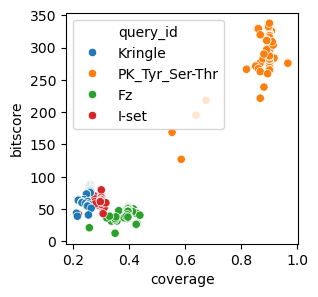

In [4]:
domset = domtblout.groupby('hit_id')['query_id'].apply(set).reset_index()
ror_outer ={'Kringle','PK_Tyr_Ser-Thr'} # 'Fz',
ror = domset[domset.query_id.apply(lambda x: ror_outer.issubset(x))]
ror.columns = ['hit_id','domains']
ror = pd.merge(domtblout,ror)

plt.figure(figsize=(3,3))
sns.scatterplot(data=ror,x='coverage',y='bitscore',hue='query_id')

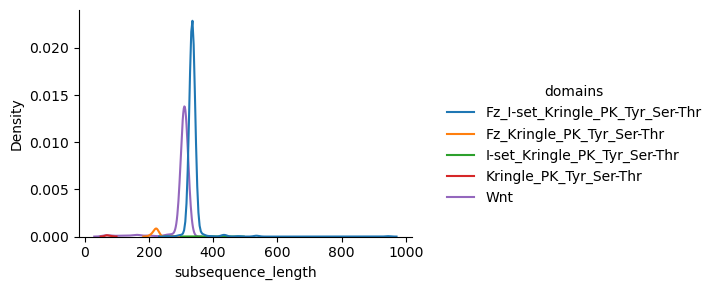

In [5]:
wnt_ror = pd.concat([wnt,ror])

# get start and end for extracellular domains, excluding cytoplasmic kinase domains
hit = wnt_ror[~wnt_ror.query_id.str.contains('PK')]
env_start = hit.sort_values('env_start').drop_duplicates('hit_id')[['hit_id','env_start']]
env_end = hit.sort_values('env_end',ascending=False).drop_duplicates('hit_id')[['hit_id','env_end']]
hits = pd.merge(env_start,env_end)

propkl = pd.read_pickle('../data/wnt_ror/pro.pkl.gz')
pro = propkl[['accession','Name','sequence','Species','taxid','Protein']].reset_index(drop=True)
pro['accession'] = pro.accession.str.split().apply(lambda x: x[0])
pro = pd.merge(pro,domset.rename(columns={'hit_id':'accession'})).reset_index(drop=True)
pro = pd.merge(pro,hits.rename(columns={'hit_id':'accession'}),on='accession').reset_index(drop=True)
pro['range'] = pro[['sequence','env_start','env_end']].values.tolist()
pro['subsequence'] = pro['range'].apply(lambda x: x[0][x[1]:x[2]+1])
pro['subsequence_length'] = pro.subsequence.apply(len)
pro['domains'] = pro.query_id.apply(lambda x: '_'.join(sorted(x)))
pro['domains'] = pro['domains'].str.replace('wnt','Wnt') 

sns.displot(data=pro,x='subsequence_length',hue='domains',kind='kde',height=3,aspect=1.5)

In [6]:
pro['taxid'] = pro.taxid.astype(int)
wnt = pro[pro.query_id.apply(lambda x: len(x)==1)].copy()
wnt['name'] = wnt['accession'].str.split('|').apply(lambda x: x[2])
ror = pro[pro.query_id.apply(lambda x: len(x)>1)].copy()
ror['name'] = ror['accession'].str.split('|').apply(lambda x: x[2])

pro = pd.merge(wnt,ror,on='taxid')
pro['name'] = pro['name_x'] + '_and_' + pro['name_y']
pro['seqres'] = pro['subsequence_x'] + ':' + pro['subsequence_y']
pro[['name','seqres']].head()

,name,seqres
0,A0A096MZ93_PAPAN_and_A0A096N7B7_PAPAN,SQLEGLSQGQKKLCHLYQDHMQYIGEGAKTGIKECQYQFRHRRWNC...
1,A0A096MZ93_PAPAN_and_A0A8I5N798_PAPAN,SQLEGLSQGQKKLCHLYQDHMQYIGEGAKTGIKECQYQFRHRRWNC...
2,A0A096MZ93_PAPAN_and_A0A8I5N3H5_PAPAN,SQLEGLSQGQKKLCHLYQDHMQYIGEGAKTGIKECQYQFRHRRWNC...
3,A0A0D9RKB7_CHLSB_and_A0A0D9S731_CHLSB,SQLEGLSQGQKKLCHLYQDHMQYIGEGAKTGIKECQYQFRHRRWNC...
4,A0A0D9RKB7_CHLSB_and_A0A0D9R4I9_CHLSB,SQLEGLSQGQKKLCHLYQDHMQYIGEGAKTGIKECQYQFRHRRWNC...


In [7]:
lineages = pd.read_pickle('../data/wnt_ror/lineages.pkl.gz')
lineages['taxid'] = lineages.taxid.astype(int)
pro = pd.merge(pro,lineages[lineages['rank']=='class'])
pro.reset_index(drop=True, inplace=True)
pro.value_counts('lineage')

lineage
Mammalia          761
Actinopteri       256
Amphibia          129
Aves              128
Lepidosauria       61
Arachnida          19
Cladistia          15
Enoplea             8
Leptocardii         8
Insecta             7
Chondrichthyes      6
Anthozoa            2
Malacostraca        2
Chromadorea         1
Thecostraca         1
Name: count, dtype: int64

In [8]:
# Genomes found in UCSC Genome Browser
# H. sapiens 9606
# M. musculus 10090
# D. rerio 7955
# Xenopus tropicalis 8364
# Gallus gallus 9031
# Callorhinchus milii 7868
# Petromyzon marinus 7757
# C. elegans 6239
# D. melanogaster 7227
# Aplysia californica 6500
selected = pd.DataFrame({'taxid':[9606,10090,7955,8364,9031,7868,7757,6239,7227,6500]})
selected = pd.merge(pro,selected)
selected.taxid.unique()
selected.to_pickle('../data/wnt_ror/selected.pkl.gz')
selected[['name','seqres']].to_csv('../data/wnt_ror/selected.csv',index=None)

array([10090,  9606,  9031,  7868,  7955,  7227,  8364,  6239])

#### Run ESMFlow to generate protein complex ensemble on the Aoraki HPC

```
sbatch --array=1-99 alphaflow_SLURM.sh
sbatch usalign_SLURM.sh
```

#### Plot TM-scores of ESMFlow predicted complexes

In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


scores = []
for i in glob('../../../ppi/doc/alphaflow/output/*.usalign.pkl.gz'):
    score = pd.read_pickle(i).reset_index(drop=True).reset_index()
    score['TM-scores'] = score['TM-scores'].apply(lambda x: x[0])
    score['model'] = score['model'].str.replace('/home/limch05p/doc/alphaflow/output/','').str.replace('_relaxed.pdb','')
    score = score[['index','model','TM-scores','RMSD']]
    score.columns = ['model','pair','TM-scores','RMSD']
    scores.append(score)

scores = pd.concat(scores)
scores['Species'] = scores['pair'].str.split('_').apply(lambda x: x[1])

sp = {'HUMAN':'Homo sapiens',
      'MOUSE':'Mus musculus',
      'CHICK':'Gallus gallus',
      'XENTR':'Xenopus tropicalis',
      'DANRE':'Danio rerio',
      'DROME':'Drosophila melanogaster',
      'CAEEL':'Caenorhabditis elegans',
      'CALMI':'Callorhinchus milii'}

scores['Species'] = scores.Species.apply(lambda x: sp[x])

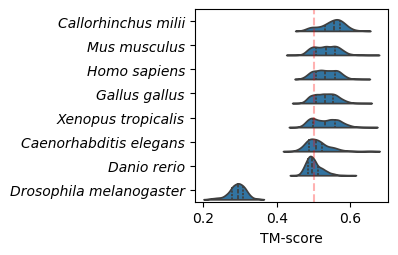

In [2]:
plt.figure(figsize=(2.5,2.5))

order = scores.groupby('Species')['TM-scores'].median().sort_values().iloc[::-1].index
g=sns.violinplot(data=scores, x='TM-scores', y='Species', split=True, inner="quart", order=order)
g.set_yticks(order)
g.set_yticklabels(labels=order, fontstyle='italic')
g.set(ylabel=None)

plt.axvline(x=0.5, color='r', linestyle='--', alpha=0.3)
plt.xlabel('TM-score')

plt.savefig('../figs/esmflow_tmscores.pdf', bbox_inches='tight')

In [3]:
scores[scores['TM-scores']>0.5].shape[0] / scores.shape[0]

0.7538989898989898

#### Plot contact map for ESMFlow trajectory

In [1]:
import mdtraj as md
from contact_map import ContactFrequency
import seaborn as sns
import matplotlib.pyplot as plt

traj = md.load('../data/wnt_ror/esmflow_out/WNT5A_HUMAN_and_ROR2_HUMAN.pdb.gz')
traj_contacts = ContactFrequency(traj)
traj_contacts = traj_contacts.residue_contacts.df
# traj_contacts.index = list(range(69,69+311)) + list(range(60,60+335))
# traj_contacts.columns = list(range(69,69+311)) + list(range(60,60+335))
traj_contacts.index = list(range(70,70+311)) + list(range(61,61+335))
traj_contacts.columns = list(range(70,70+311)) + list(range(61,61+335))

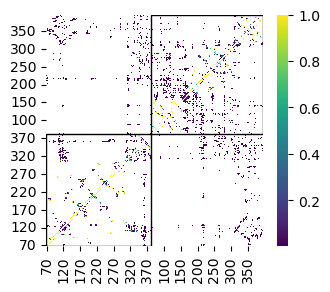

In [2]:
plt.figure(figsize=(3.5,3))
ax = sns.heatmap(traj_contacts, cmap='viridis', xticklabels = 50, yticklabels = 50)
ax.invert_yaxis()
ax.axvspan(xmin=0, xmax=311, ymax=311/traj_contacts.shape[0], edgecolor='k', facecolor='None')
ax.axvspan(xmin=311, xmax=traj_contacts.shape[0], ymin=311/traj_contacts.shape[0], edgecolor='k', facecolor='None')
plt.savefig('../figs/contact_map.pdf')

#### Calculate and plot RMSF

In [1]:
# import pandas as pd
# import mdtraj as md

# traj=md.load('../data/wnt_ror/WNT5A_HUMAN_and_ROR2_HUMAN.pdb.gz')
traj.atom_slice([a.index for a in traj.top.atoms if a.element.symbol != 'H'], True)
traj.atom_slice([a.index for a in traj.top.atoms if a.name == 'CA'], True)
traj.n_atoms

rmsf = md.rmsf(traj, traj, 0)
rmsf.shape

(646,)

In [2]:
selected = pd.read_csv('../data/wnt_ror/selected.csv')
selected['lengths'] = selected['seqres'].str.split(':').apply(lambda x: [len(i) for i in x])
selected[selected['name']=='WNT5A_HUMAN_and_ROR2_HUMAN'].seqres.iloc[0]

'SQLAGLSQGQKKLCHLYQDHMQYIGEGAKTGIKECQYQFRHRRWNCSTVDNTSVFGRVMQIGSRETAFTYAVSAAGVVNAMSRACREGELSTCGCSRAARPKDLPRDWLWGGCGDNIDYGYRFAKEFVDARERERIHAKGSYESARILMNLHNNEAGRRTVYNLADVACKCHGVSGSCSLKTCWLQLADFRKVGDALKEKYDSAAAMRLNSRGKLVQVNSRFNSPTTQDLVYIDPSPDYCVRNESTGSLGTQGRLCNKTSEGMDGCELMCCGRGYDQFKTVQTERCHCKFHWCCYVKCKKCTEIVDQFVCK:FLNFLEPVNNITIVQGQTAILHCKVAGNPPPNVRWLKNDAPVVQEPRRIIIRKTEYGSRLRIQDLDTTDTGYYQCVATNGMKTITATGVLFVRLGPTHSPNHNFQDDYHEDGFCQPYRGIACARFIGNRTIYVDSLQMQGEIENRITAAFTMIGTSTHLSDQCSQFAIPSFCHFVFPLCDARSRTPKPRELCRDECEVLESDLCRQEYTIARSNPLILMRLQLPKCEALPMPESPDAANCMRIGIPAERLGRYHQCYNGSGMDYRGTASTTKSGHQCQPWALQHPHSHHLSSTDFPELGGGHAYCRNPGGQMEGPWCFTQNKNVRMELCDVPSCS'

Text(0, 0.5, 'RMSF($\\AA$)')

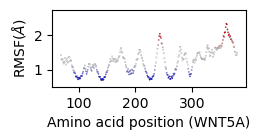

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ['Blue', 'White', 'White','Red', 'Red']  # Red, Green, Blue
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom', colors)

wnt5_rmsf = pd.DataFrame({'Position':list(range(69,69+311)), 'RMSF':rmsf[:311]})

plt.figure(figsize=(2.5,1))
sns.scatterplot(data=wnt5_rmsf, x='Position',y='RMSF', s=1, hue='RMSF', hue_norm=(0.69,2.5), palette=cmap_custom,
           edgecolor='black', linewidths=0.1, legend=None)
plt.ylim(0.5,2.75)
plt.xlabel('Amino acid position (WNT5A)')
plt.ylabel(r'RMSF($\AA$)')
plt.savefig('../figs/rmsf_WNT5A.pdf', bbox_inches='tight')

Text(0, 0.5, 'RMSF($\\AA$)')

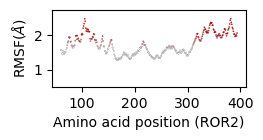

In [4]:
ror2_rmsf = pd.DataFrame({'Position':list(range(60,60+335)), 'RMSF':rmsf[311:]})

plt.figure(figsize=(2.5,1))
sns.scatterplot(data=ror2_rmsf, x='Position',y='RMSF', s=1, hue='RMSF', hue_norm=(0.69,2.5), palette=cmap_custom,
           edgecolor='black', linewidths=0.1, legend=None)
plt.ylim(0.5,2.75)
plt.xlabel('Amino acid position (ROR2)')
plt.ylabel(r'RMSF($\AA$)')
plt.savefig('../figs/rmsf_ROR2.pdf', bbox_inches='tight')